In [165]:
import pandas as pd
import numpy as np
import bitmexData 
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

# Load the Data from CSV

In [2]:
sentiment = pd.read_csv('augmento_assignment_data.csv').set_index('date')
sentiment.index = pd.to_datetime(sentiment.index)

# Get the Data from API


In [3]:
# need max amount of points is about 12000. Need to run twice to get data
year1 = bitmexData.Hourly('2016-11-01','2018-03-07','XBTUSD')
df1 = year1.get_data_all()
year2 = bitmexData.Hourly('2018-03-07','2019-03-08','XBTUSD')
df2 = year2.get_data_all()

Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loaded.
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loaded.


In [4]:
data1 = pd.DataFrame(df1)
data2 = pd.DataFrame(df2)
df = pd.concat([data1,data2],axis=0)

In [5]:
# df[df.duplicated()]
# remove duplicates
data = df.drop_duplicates().set_index('timestamp')
data.index = pd.to_datetime(data.index)

# Find the ratio of positive to negative sentiment

$$ ratio = \frac{positive + 1}{negative + 1}$$

1 was added to numerator and denominator to account for $\frac{0}{0}$ and $\frac{x}{0}$


In [133]:

sentiment["ratio_pn"]=(sentiment["Positive"]+1)/(sentiment["Negative"]+1)

# Standardize time series

Since you mentioned "stationarity," I assume you meant percentage change of the <b>Close</b> data.
<br>
<b>Stationarity</b>: mean and variance constant over time

<b>Another Method</b>
<br>
Rolling Window
<br>
<i>std is adjusted depending on the window</i>



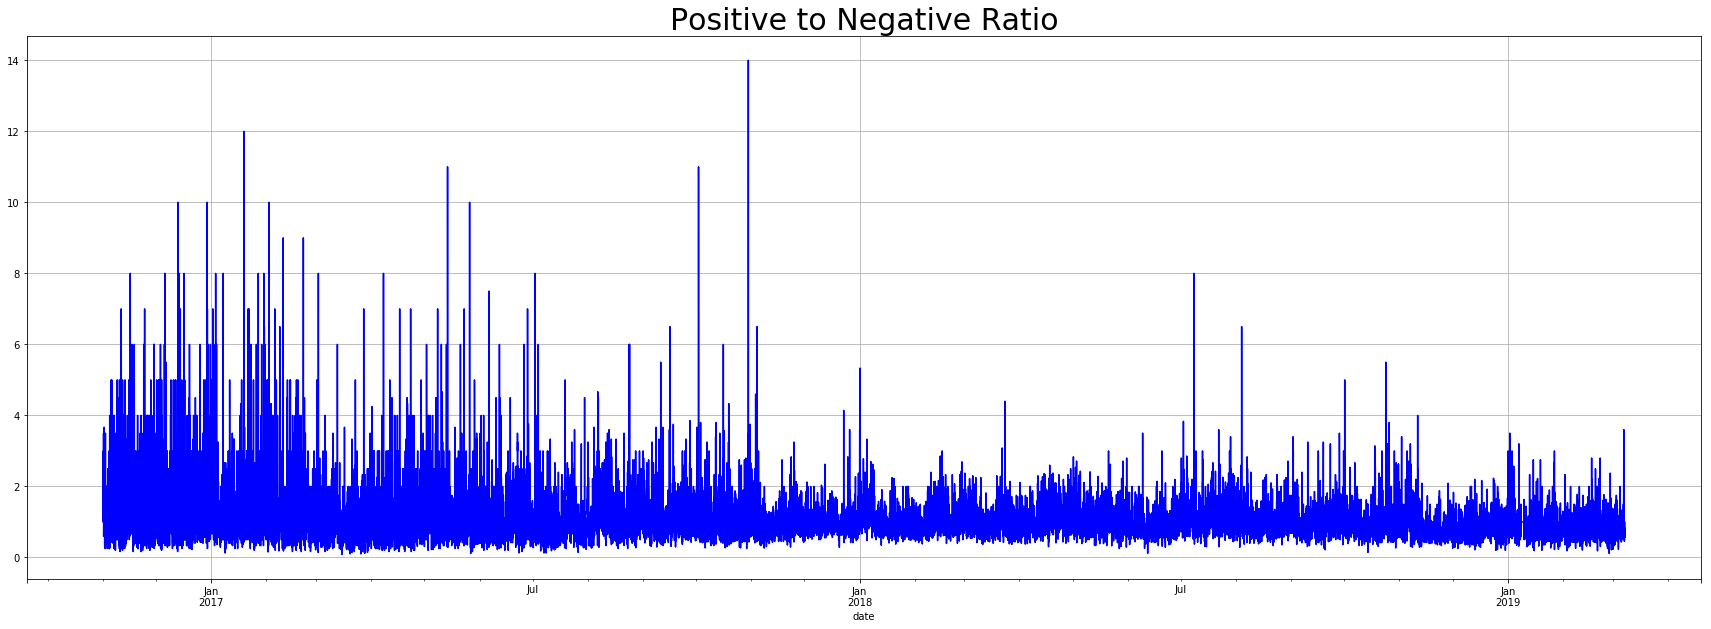

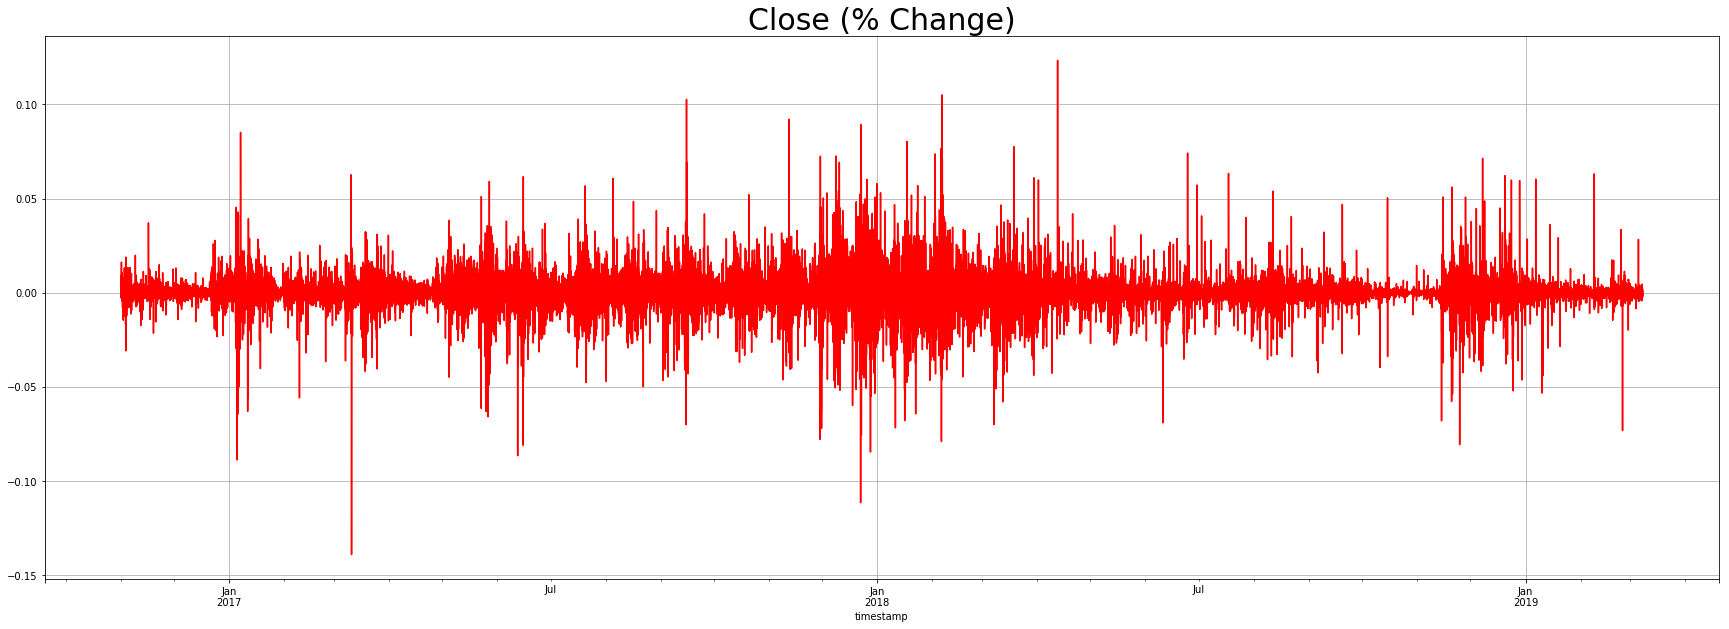

In [121]:
plt.figure(figsize=(30,10))
plt.title('Positive to Negative Ratio', fontsize=30)
ax1 = sentiment.ratio_pn.plot(color='blue', grid=True)
plt.figure(figsize=(30,10))
plt.title('Close (% Change)', fontsize=30)
ax1 = (data.close).pct_change().plot(color='red', grid=True)

#h1, l1 = ax1.get_legend_handles_labels()

#plt.legend(h1, l1, loc=2)
plt.show()

# Second try without centering data

/Users/hoangluong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  
/Users/hoangluong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  This is separate from the ipykernel package so we can avoid doing imports until


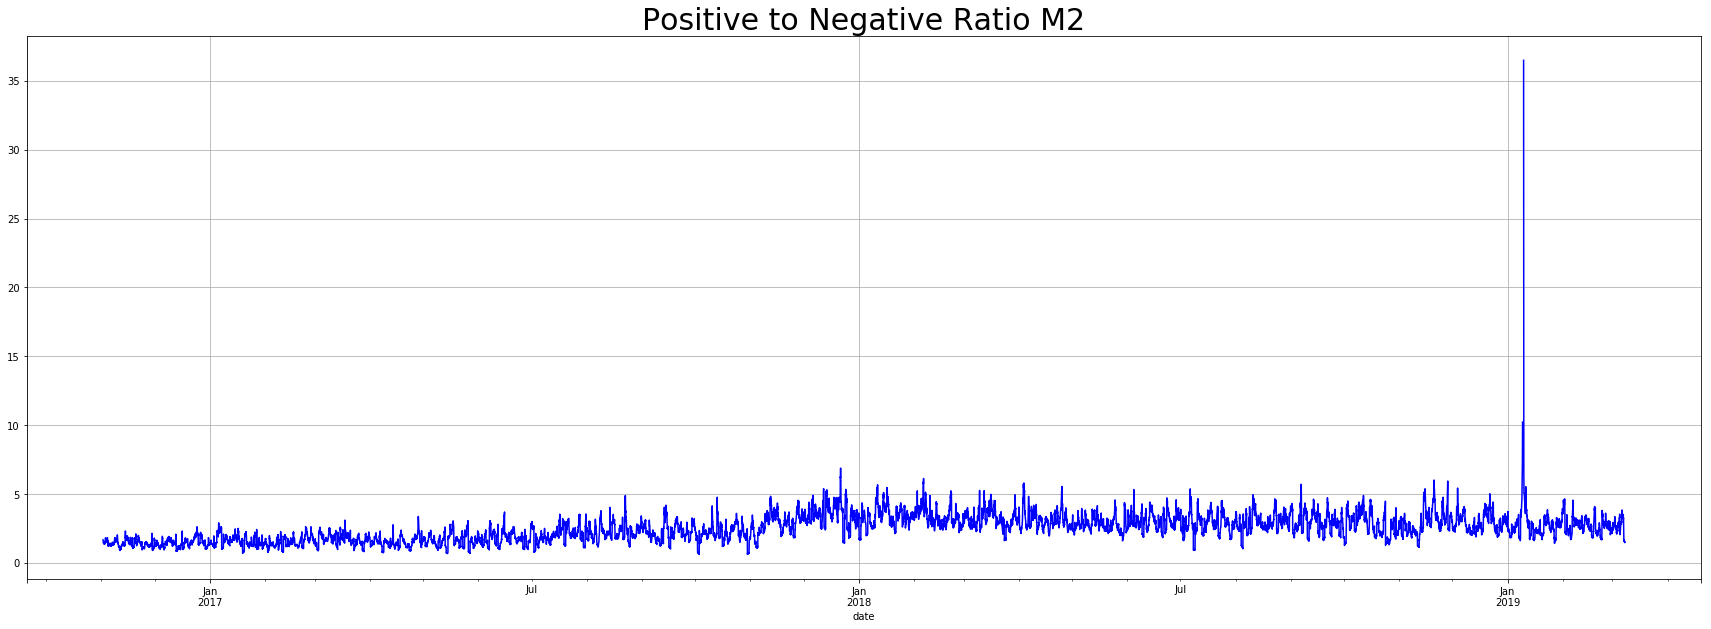

In [127]:
win=24
mean = pd.Series(sentiment["ratio_pn"]).rolling(window=win).apply(lambda x : np.mean(x))
std = pd.Series(sentiment["ratio_pn"]).rolling(window=win).apply(lambda x : np.std(x))
m2 =  (mean)/std
m2 = m2.rename("stat_ratio_pn")
plt.figure(figsize=(30,10))
plt.title('Positive to Negative Ratio M2', fontsize=30)
ax1 = m2.plot(color='blue', grid=True)

plt.show()

In [128]:
rc = pd.merge(pd.DataFrame((data.close)), pd.DataFrame(m2), left_index=True, right_index=True).dropna()


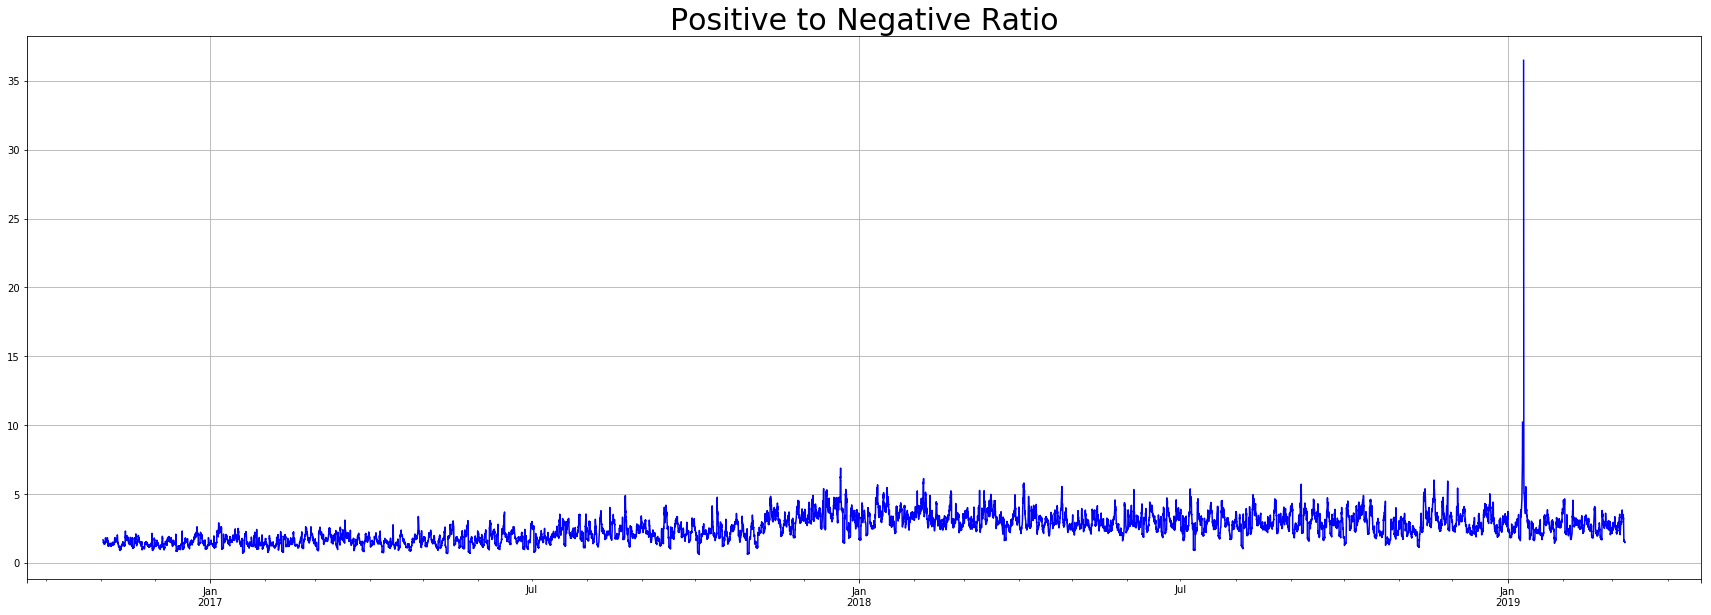

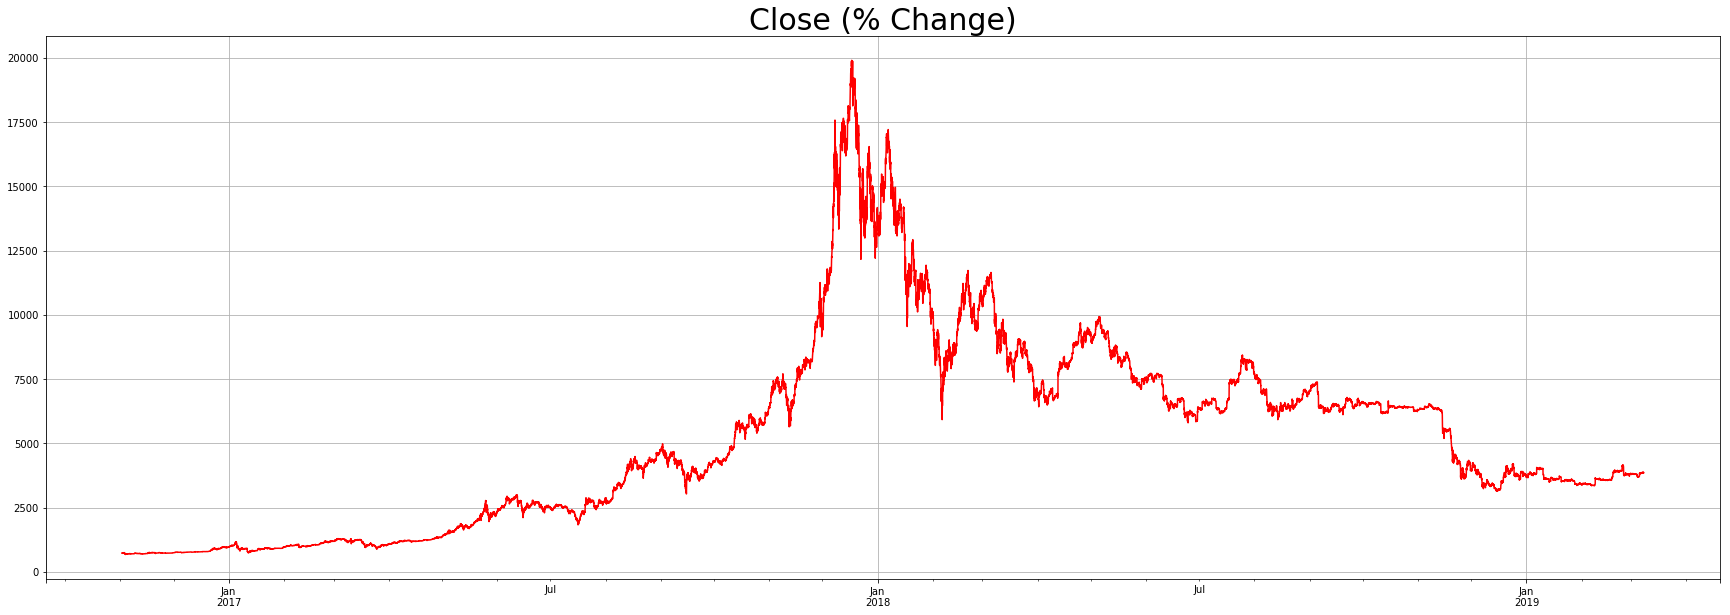

In [129]:
plt.figure(figsize=(30,10))
plt.title('Positive to Negative Ratio', fontsize=30)
ax1 = rc.stat_ratio_pn.plot(color='blue', grid=True)
plt.figure(figsize=(30,10))
plt.title('Close (% Change)', fontsize=30)
ax1 = (rc.close).plot(color='red', grid=True)

#h1, l1 = ax1.get_legend_handles_labels()

plt.show()

# Correlation

In [130]:
rc.corr()

,close,stat_ratio_pn
close,1.000000,0.583319
stat_ratio_pn,0.583319,1.000000


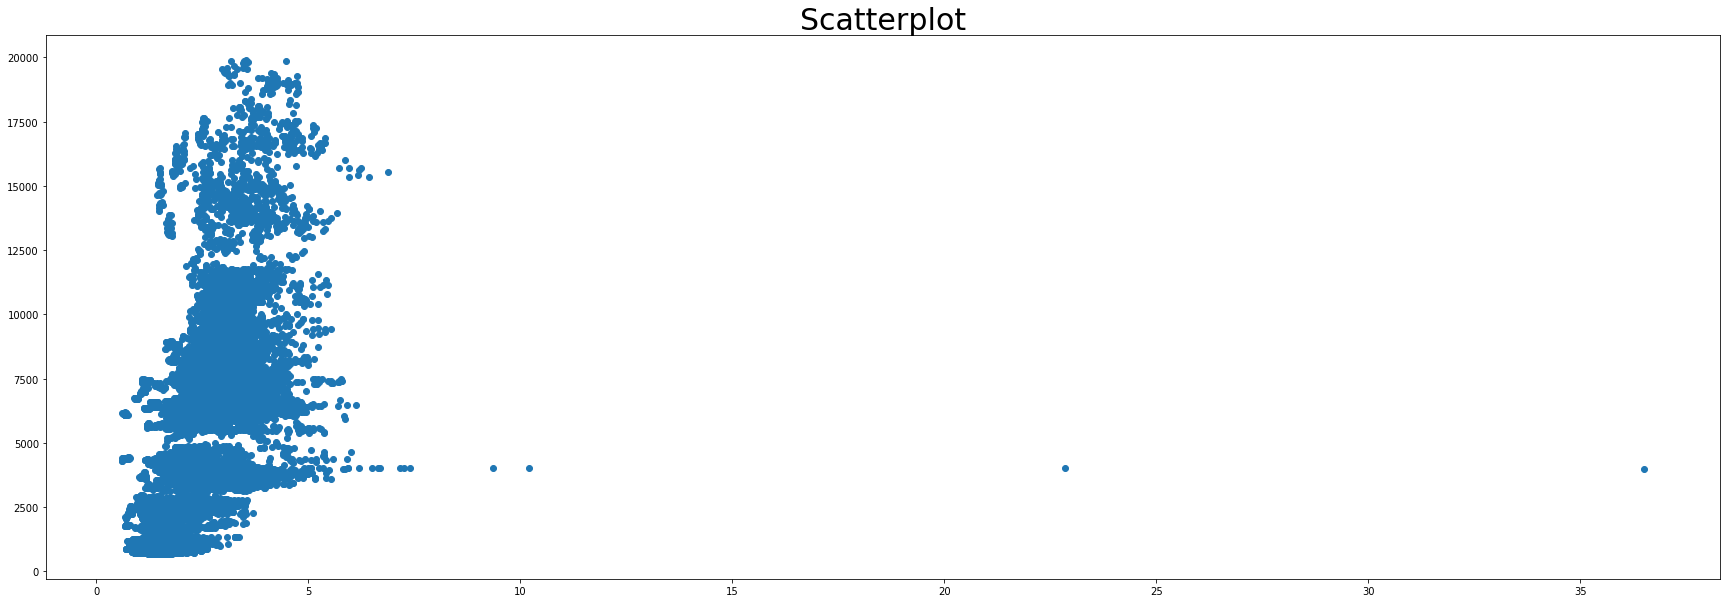

In [131]:
plt.figure(figsize=(30,10))
plt.title('Scatterplot', fontsize=30)
plt.scatter(rc.stat_ratio_pn,rc.close)
plt.show()

# Another Ratio

$$ ratio = \frac{positive}{negative + positive}$$


In [135]:
sentiment["ratio_pn"]=(sentiment["Positive"])/(sentiment["Negative"]+sentiment["Positive"])


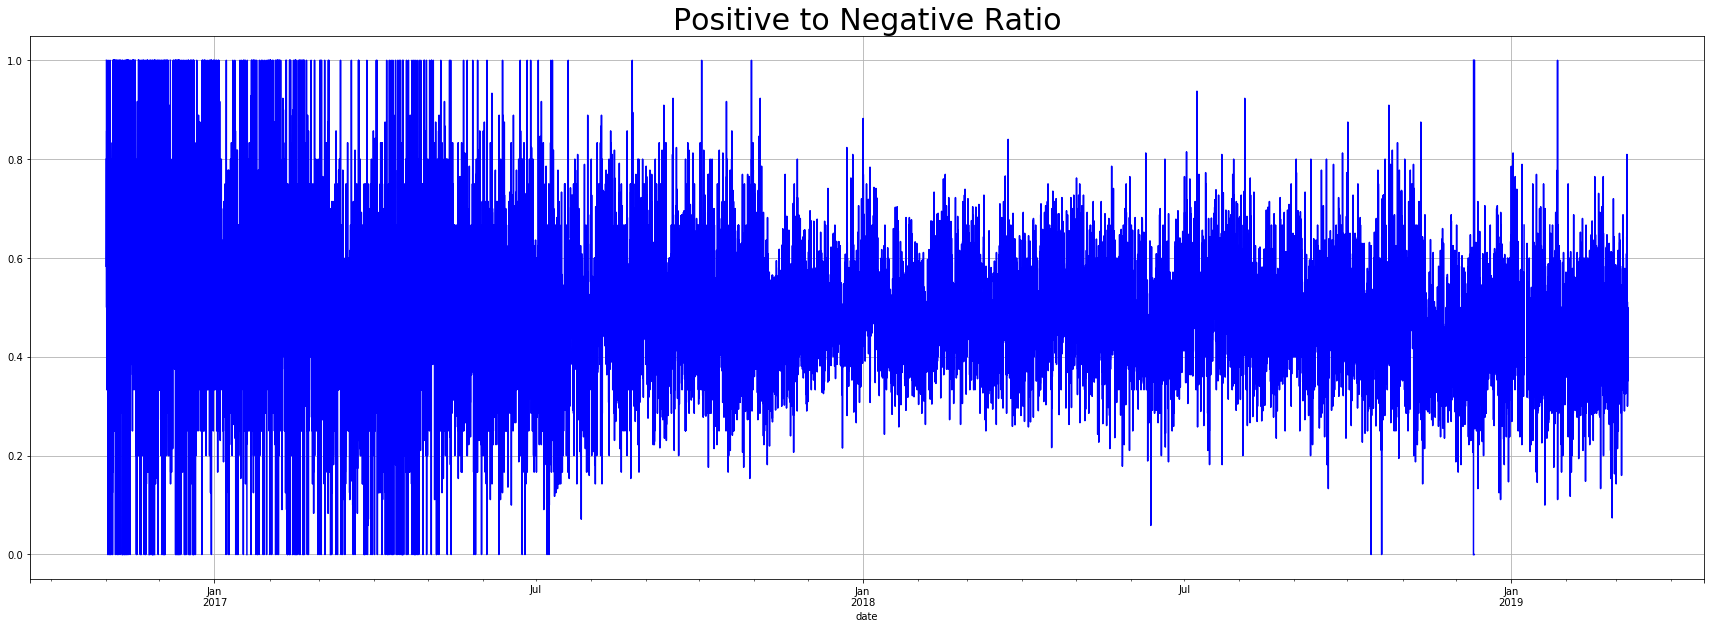

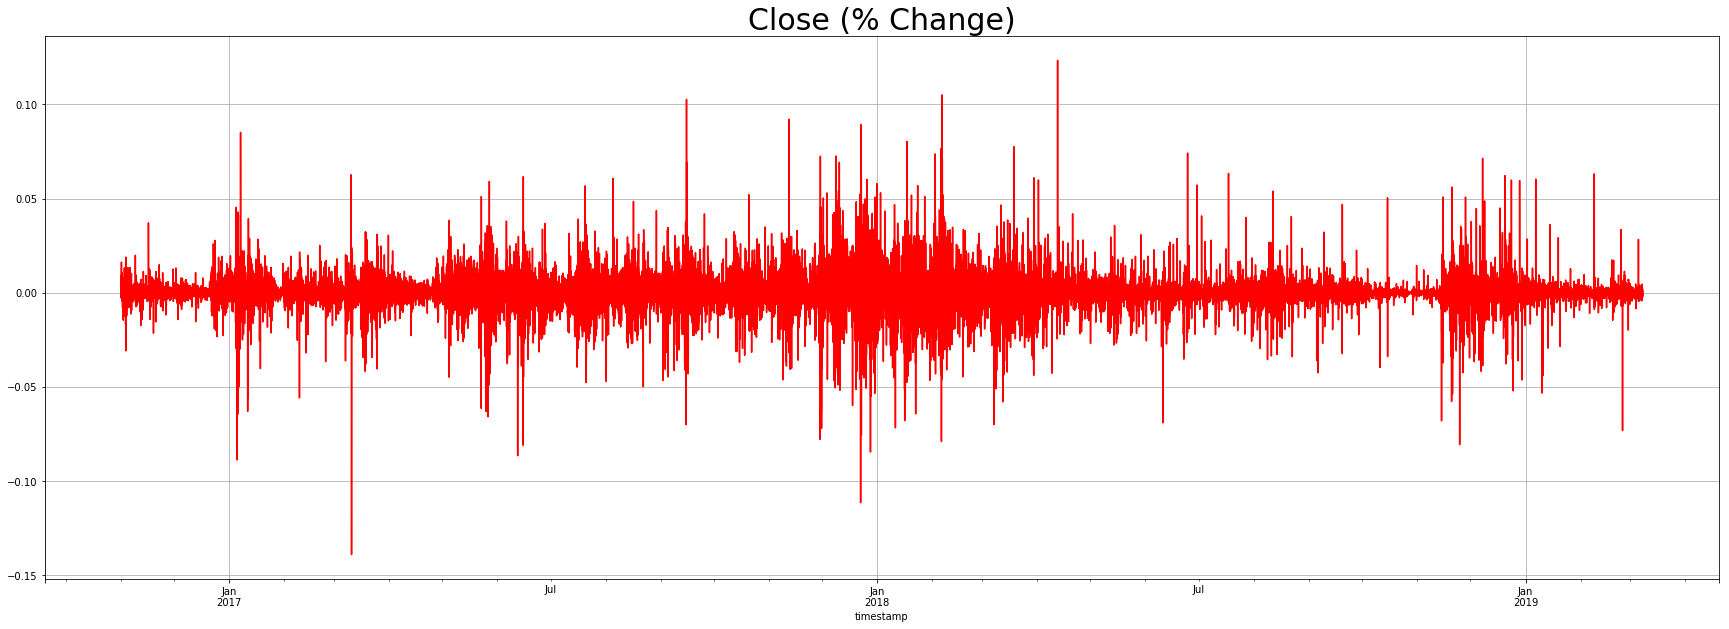

In [136]:
plt.figure(figsize=(30,10))
plt.title('Positive to Negative Ratio', fontsize=30)
ax1 = sentiment.ratio_pn.plot(color='blue', grid=True)
plt.figure(figsize=(30,10))
plt.title('Close (% Change)', fontsize=30)
ax1 = (data.close).pct_change().plot(color='red', grid=True)

#h1, l1 = ax1.get_legend_handles_labels()

#plt.legend(h1, l1, loc=2)
plt.show()

/Users/hoangluong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  
/Users/hoangluong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  This is separate from the ipykernel package so we can avoid doing imports until


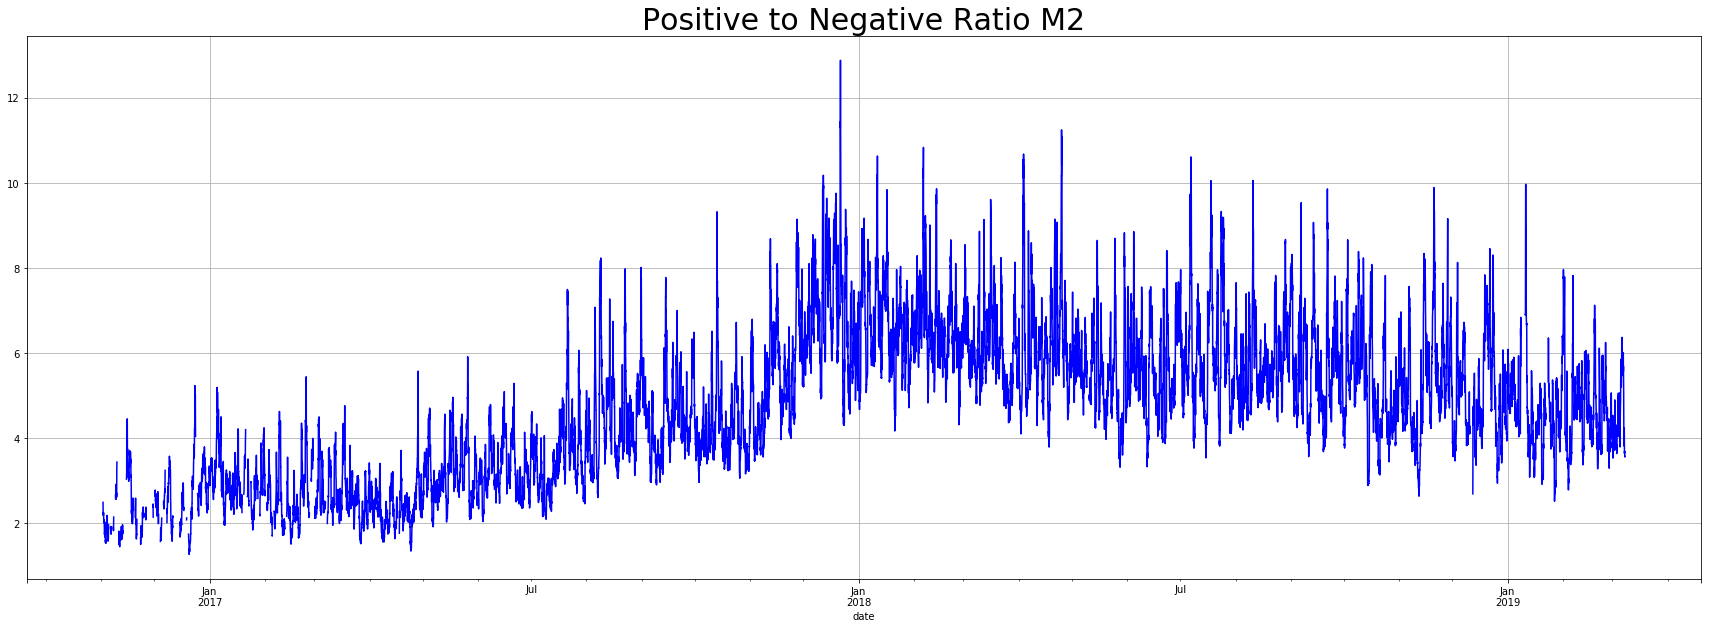

In [139]:
win=24
mean = pd.Series(sentiment["ratio_pn"]).rolling(window=win).apply(lambda x : np.mean(x))
std = pd.Series(sentiment["ratio_pn"]).rolling(window=win).apply(lambda x : np.std(x))
m2 =  mean/std
m2 = m2.rename("stat_ratio_pn")
plt.figure(figsize=(30,10))
plt.title('Positive to Negative Ratio M2', fontsize=30)
ax1 = m2.plot(color='blue', grid=True)

plt.show()

In [141]:
rc = pd.merge(pd.DataFrame((data.close)), pd.DataFrame(m2), left_index=True, right_index=True).dropna()


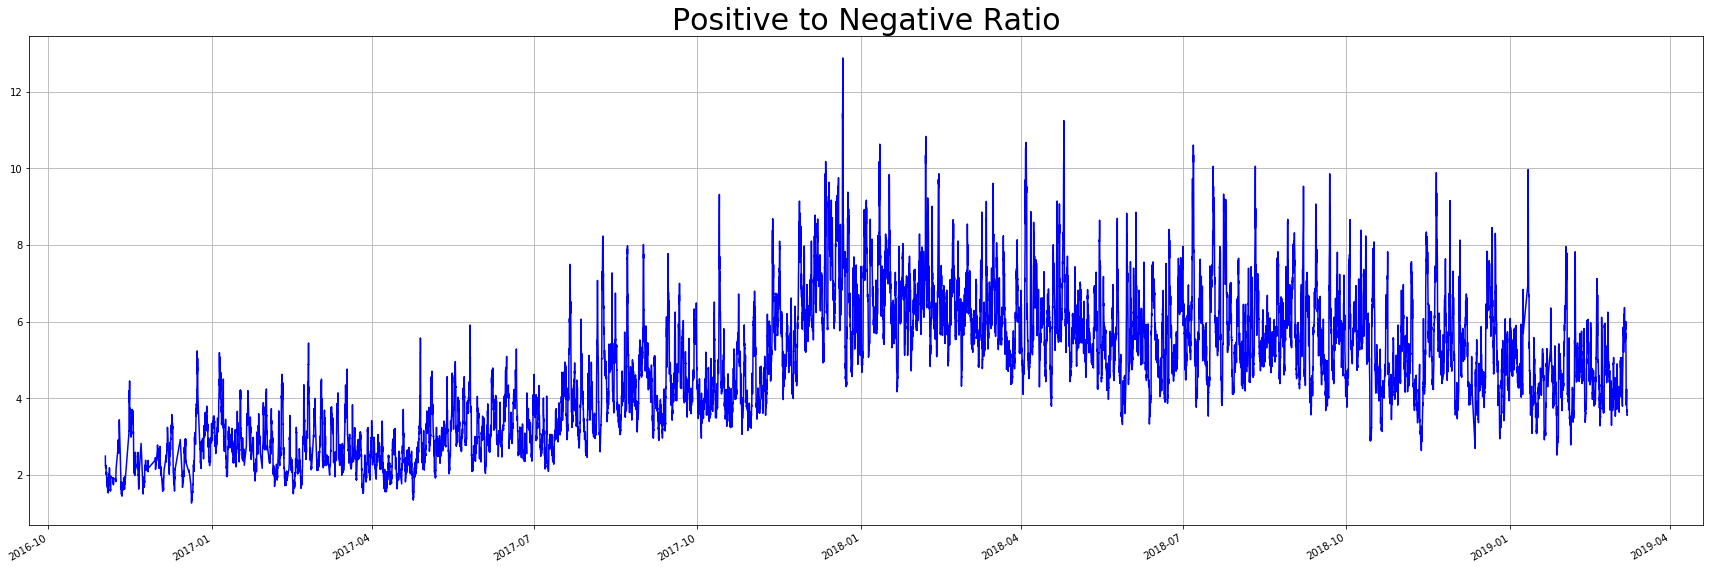

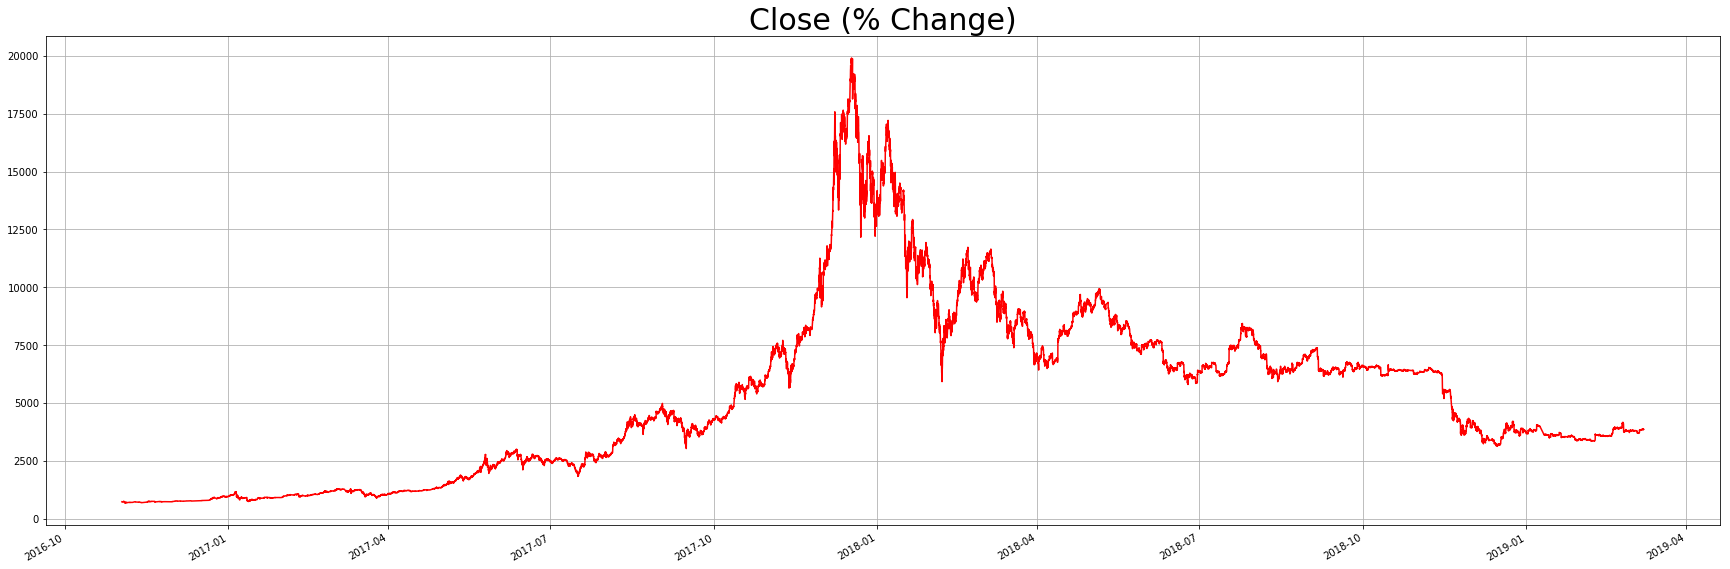

In [142]:
plt.figure(figsize=(30,10))
plt.title('Positive to Negative Ratio', fontsize=30)
ax1 = rc.stat_ratio_pn.plot(color='blue', grid=True)
plt.figure(figsize=(30,10))
plt.title('Close (% Change)', fontsize=30)
ax1 = (rc.close).plot(color='red', grid=True)

#h1, l1 = ax1.get_legend_handles_labels()

plt.show()

In [144]:
# We get much higher correlation
rc.corr()

,close,stat_ratio_pn
close,1.000000,0.732363
stat_ratio_pn,0.732363,1.000000


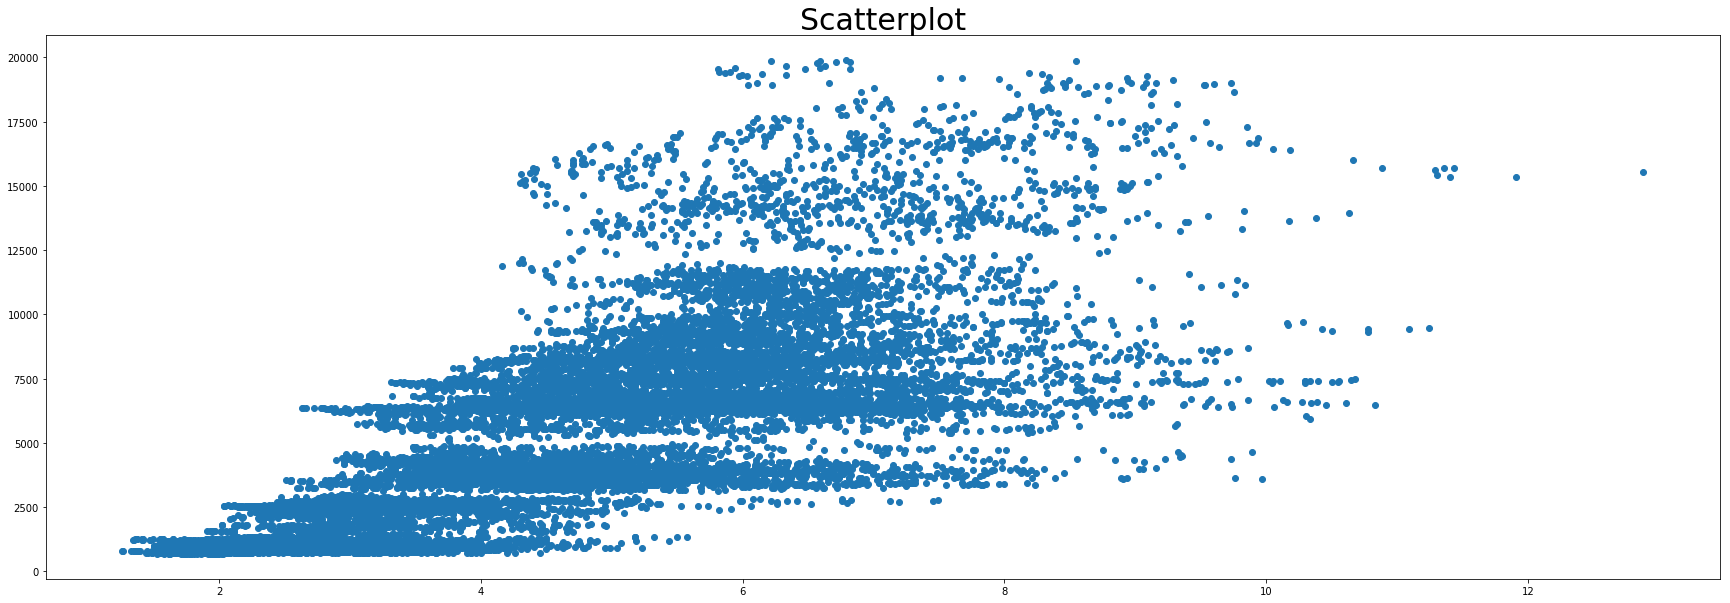

In [194]:
plt.figure(figsize=(30,10))
plt.title('Scatterplot', fontsize=30)
plt.scatter(rc.stat_ratio_pn,rc.close)
plt.show()

# Plot against each other
<b>Steps</b>:
1. normalize
2. plot

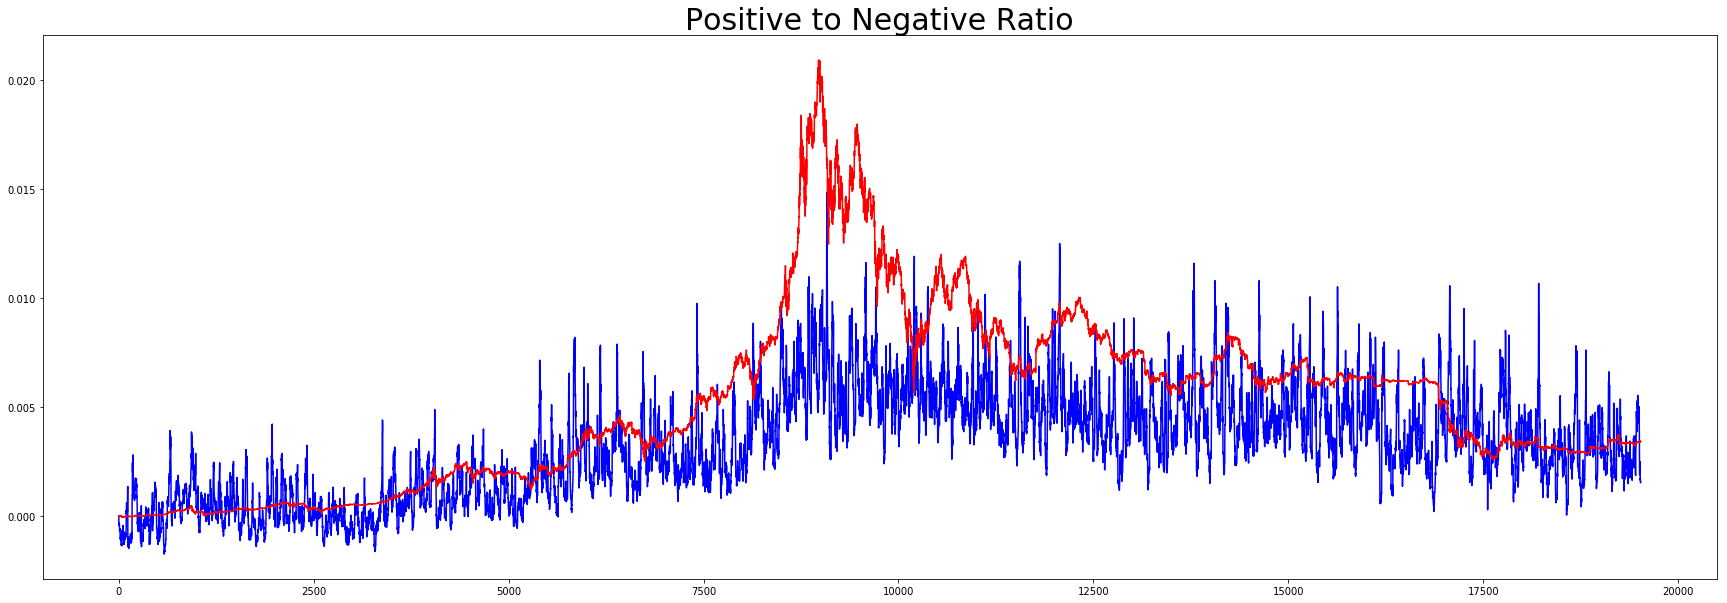

In [220]:
ratio = preprocessing.normalize([rc.stat_ratio_pn])[0]
close = preprocessing.normalize([rc.close])[0]
# start at the same point
ratio = ratio-ratio[0]
close = close-close[0]

plt.figure(figsize=(30,10))
plt.title('Positive to Negative Ratio', fontsize=30)
p1 = plt.plot(ratio, color='blue')
p2 = plt.plot(close, color='red')


plt.show()